# Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from datetime import datetime, date
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from sklearn.metrics import r2_score

2024-10-03 23:15:18.312563: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-03 23:15:18.317122: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-03 23:15:18.332467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 23:15:18.357771: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 23:15:18.365577: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 23:15:19.839759: W tensorflow/compiler/tf2tensorrt/utils/p

# Input data - dropping date and bitcoin opening, high and low prices

In [2]:
data = pd.read_csv('/home/hoangbaoan1901/Development/predictive-analysis/Homeworks/week-3-btl/datasets/jrfm-2156907-cleaned.csv')

In [3]:
data = data.drop(columns=['Date'])

In [4]:
data.head()

,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,Active Addr Cnt,Xfer Cnt,Mean Tx Size (native units),Total Fees (USD),Mean Hash Rate,...,RUB,Tweets,Google,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,278.740997,280.391998,276.365997,279.584991,42484800.0,283150,497302,2.057514,7235.134845,356031.3023,...,64.480003,47467,90.000000,0,0,0,0,1,0,0
1,279.742004,279.928009,260.709991,260.997009,58533000.0,266587,284532,3.675623,5806.842316,420413.4050,...,64.480003,29031,91.578947,0,0,0,0,0,1,0
2,261.115997,267.002991,260.467987,265.083008,23789600.0,262571,276720,4.201519,4952.554125,372000.7193,...,64.480003,27132,91.578947,0,0,0,0,0,0,1
3,265.477997,267.032013,262.596008,264.470001,20979400.0,292834,304538,3.463212,7563.840456,437493.8037,...,64.480003,27744,96.315789,1,0,0,0,0,0,0
4,264.342010,270.385986,264.093994,270.385986,25433900.0,271613,280398,3.785274,7128.842169,424395.1868,...,62.889999,26653,104.210526,0,1,0,0,0,0,0


In [5]:
data.shape

(2430, 47)

In [6]:
data.isna().sum()

BTC_Open                       0
BTC_High                       0
BTC_Low                        0
BTC_Close                      0
BTC_Volume                     0
Active Addr Cnt                0
Xfer Cnt                       0
Mean Tx Size (native units)    0
Total Fees (USD)               0
Mean Hash Rate                 0
Difficulty                     0
Mean Block Size (in bytes)     0
Sum Block Weight               0
LTC                            0
XRP                            0
DASH                           0
DOGE                           0
ETH                            0
Gold                           0
Silver                         0
Copper                         0
Oil                            0
Treasury Yield 10 Years        0
S&P500                         0
DJI                            0
CBOE                           0
NASDAQ                         0
JP225                          0
CSI300                         0
DXY                            0
EUR       

# Split data into train and test set

In [7]:
# Define train size, test size = 1 - train size
train_size = int(len(data) * 0.7)
train_set = data.iloc[:train_size]
test_set = data.iloc[train_size:]

In [8]:
# Define the target variable
target = 'BTC_Close'

# Create the feature sets
X_train = train_set.drop(columns=[target])
X_test = test_set.drop(columns=[target])

# Create the target sets
Y_train = train_set[target]
Y_test = test_set[target]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

ts = 1 # Define the time step
# Create sequences with a time step of 10
def create_sequences(data, target, time_step=ts):
	X, y = [], []
	for i in range(len(data) - time_step):
		X.append(data[i:(i + time_step)])
		y.append(target[i + time_step])
	return np.array(X), np.array(y)

X_train, Y_train = create_sequences(X_train.values, Y_train.values)
X_test, Y_test = create_sequences(X_test.values, Y_test.values)

print("X_train shape after sequencing:", X_train.shape)
print("X_test shape after sequencing:", X_test.shape)
print("Y_train shape after sequencing:", Y_train.shape)
print("Y_test shape after sequencing:", Y_test.shape)

X_train shape: (1701, 46)
X_test shape: (729, 46)
Y_train shape: (1701,)
Y_test shape: (729,)
X_train shape after sequencing: (1700, 1, 46)
X_test shape after sequencing: (728, 1, 46)
Y_train shape after sequencing: (1700,)
Y_test shape after sequencing: (728,)


# Normalize data with MinMaxScaler

In [9]:
# Normalize the datasets using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Update the variables used for training
X_train = X_train_scaled
X_test = X_test_scaled

print(X_train) 

[[[0.00356452 0.00272224 0.00409059 ... 1.         0.         0.        ]]

 [[0.00361647 0.00269888 0.0032567  ... 0.         1.         0.        ]]

 [[0.00264968 0.00204816 0.00324381 ... 0.         0.         1.        ]]

 ...

 [[0.2966651  0.31671834 0.3037981  ... 0.         0.         0.        ]]

 [[0.32288097 0.31607993 0.32888143 ... 0.         0.         0.        ]]

 [[0.3232294  0.32152021 0.31973134 ... 0.         0.         0.        ]]]


# Model initialization & compilation

In [10]:
model = tf.keras.Sequential([
	tf.keras.layers.LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
	tf.keras.layers.Dropout(0.2),
	tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
	tf.keras.layers.Dropout(0.3),
	tf.keras.layers.LSTM(256, activation='relu', return_sequences=True),
	tf.keras.layers.Dropout(0.4),
	tf.keras.layers.LSTM(256, activation='relu', return_sequences=False),
	tf.keras.layers.Dropout(0.5),
	tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

I0000 00:00:1727972122.168608  149661 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-03 23:15:22.195525: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/hoangbaoan1901/Development/predictive-analysis/Homeworks/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model 

# Fit train set with label using LSTM model, predict & visualization

In [11]:
# Fit the model
history = model.fit(X_train, Y_train, epochs=30)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 36542296.0000 - mae: 4549.6484
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5440433.5000 - mae: 1935.5660
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2308267.5000 - mae: 1155.6238
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1504321.3750 - mae: 838.4207
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1663252.5000 - mae: 805.2859
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1399501.5000 - mae: 766.0406
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1308050.6250 - mae: 707.4064
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1351713.3750 - mae: 727.1170
Epoch 9/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1194312.7500 - mae: 693.0865
Epoch 10/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1183358.5000 - mae: 677.7859
Epoch 11/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1215860.6250 - mae: 699.1943
Epoch 12/30
54/54 ━━━━━━━━

In [12]:
# Use the model to make predictions on the test set
predictions = model.predict(X_test)

# Calculate the R^2 score
r2 = r2_score(Y_test, predictions)
print("R^2 score:", r2)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
R^2 score: 0.9751484271878722


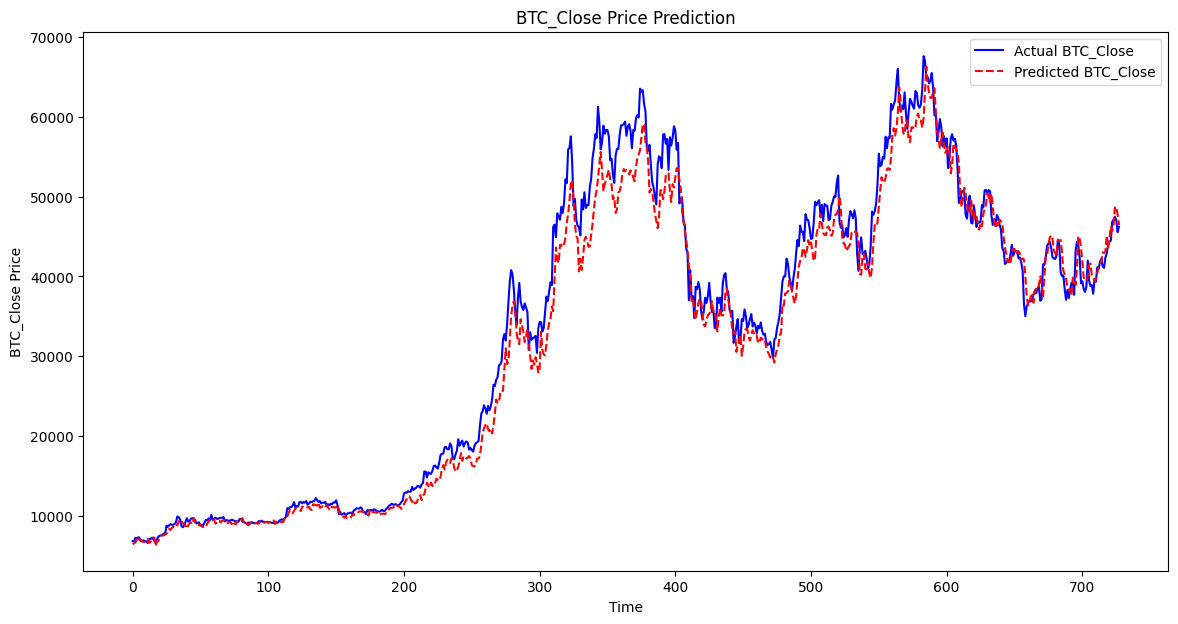

In [13]:
# Plot the predictions against the actual values
plt.figure(figsize=(14, 7))
plt.plot(Y_test, color='blue', label='Actual BTC_Close')
plt.plot(predictions, color='red', label='Predicted BTC_Close', linestyle='dashed')
plt.title('BTC_Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC_Close Price')
plt.legend()
plt.show()